In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch_geometric.transforms as T

import fish_models
import robofish.io

from SwarmNet import create_swarm_dataset, train_SwarmNet, save_model, load_model, Pose_and_View_SwarmNet, CouzinModel, Edgeweight_SwarmNet

# Data

In [2]:
# full_path = fish_models.raw_data('pascal_vanilla_couzin')
# full_path

WindowsPath('c:/users/olaf/onedrive/öffentlich/master/researchinternship/fish_models/storage/raw_data/pascal_vanilla_couzin')

In [2]:
raycast = fish_models.Raycast(
            n_fish_bins=150,
            n_wall_raycasts=150,
            fov_angle_fish_bins=2*np.pi,
            fov_angle_wall_raycasts=2*np.pi,
            world_bounds=([-50, -50], [50, 50]),
            view_of = ["fish", "fish_oris", "walls"]
        )

In [3]:
data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\fish_models\storage\raw_data\pascal_vanilla_couzin\2fish_200t_10hz_vanilla\train"

dset = fish_models.IoDataset(data_folder, raycast, output_strings=["poses", "actions", "views"], max_files=500)

data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\fish_models\storage\raw_data\pascal_vanilla_couzin\2fish_200t_10hz_vanilla\test"

dset_test = fish_models.IoDataset(data_folder,raycast,output_strings=["poses", "actions", "views"],max_files=100,
)
data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\fish_models\storage\raw_data\pascal_vanilla_couzin\2fish_200t_10hz_vanilla\validation"

dset_val = fish_models.IoDataset(data_folder,raycast,output_strings=["poses", "actions", "views"],max_files=100,
)

Loading data from 500 files.


100%|████████████████████████████████████████| 500/500 [00:08<00:00, 56.31it/s]


None
Calculating views from 500 files.


100%|████████████████████████████████████████| 500/500 [01:22<00:00,  6.05it/s]


Reducing shape of poses.


100%|█████████████████████████████████████| 500/500 [00:00<00:00, 45422.40it/s]


Reducing shape of actions.


100%|█████████████████████████████████████| 500/500 [00:00<00:00, 71489.76it/s]


Reducing shape of views.


100%|██████████████████████████████████████| 500/500 [00:00<00:00, 6497.02it/s]


Status of IoDataset:
poses	(500, 2, 199, 3):	consisting of x, y, orientation.
actions	(500, 2, 199, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(500, 2, 199, 450):	consisting of 150 fish bins, 150 fish oris and 150 wall raycasts.

Loading data from 100 files.


100%|████████████████████████████████████████| 100/100 [00:01<00:00, 59.35it/s]


None
Calculating views from 100 files.


100%|████████████████████████████████████████| 100/100 [00:16<00:00,  6.18it/s]


Reducing shape of poses.


100%|█████████████████████████████████████| 100/100 [00:00<00:00, 25046.60it/s]


Reducing shape of actions.


100%|█████████████████████████████████████| 100/100 [00:00<00:00, 33354.31it/s]


Reducing shape of views.


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 6670.22it/s]


Status of IoDataset:
poses	(100, 2, 199, 3):	consisting of x, y, orientation.
actions	(100, 2, 199, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(100, 2, 199, 450):	consisting of 150 fish bins, 150 fish oris and 150 wall raycasts.

Loading data from 100 files.


100%|████████████████████████████████████████| 100/100 [00:01<00:00, 59.62it/s]


None
Calculating views from 100 files.


100%|████████████████████████████████████████| 100/100 [00:18<00:00,  5.43it/s]


Reducing shape of poses.


100%|█████████████████████████████████████| 100/100 [00:00<00:00, 16675.16it/s]


Reducing shape of actions.


100%|█████████████████████████████████████| 100/100 [00:00<00:00, 20009.08it/s]


Reducing shape of views.


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 6672.24it/s]

Status of IoDataset:
poses	(100, 2, 199, 3):	consisting of x, y, orientation.
actions	(100, 2, 199, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(100, 2, 199, 450):	consisting of 150 fish bins, 150 fish oris and 150 wall raycasts.



In [4]:
BATCH_SIZE = 320
train_loader = create_swarm_dataset(dset["poses"], dset["actions"], dset["views"], batchsize=BATCH_SIZE, filter_distance=None)
train_loader_filter = create_swarm_dataset(dset["poses"], dset["actions"], dset["views"], batchsize=BATCH_SIZE, filter_distance=40)
test_loader = create_swarm_dataset(dset_test["poses"], dset_test["actions"], dset_test["views"], batchsize=BATCH_SIZE, filter_distance=None)
test_loader_filter = create_swarm_dataset(dset_test["poses"], dset_test["actions"], dset_test["views"], batchsize=BATCH_SIZE, filter_distance=40)
val_loader = create_swarm_dataset(dset_val["poses"], dset_val["actions"], dset_val["views"], batchsize=BATCH_SIZE, filter_distance=None)
val_loader_filter = create_swarm_dataset(dset_val["poses"], dset_val["actions"], dset_val["views"], batchsize=BATCH_SIZE, filter_distance=40)

In [5]:
train_loader_nograph = create_swarm_dataset(dset["poses"], dset["actions"], dset["views"], batchsize=BATCH_SIZE, filter_distance=0)
test_loader_nograph = create_swarm_dataset(dset_test["poses"], dset_test["actions"], dset_test["views"], batchsize=BATCH_SIZE, filter_distance=0)
val_loader_nograph = create_swarm_dataset(dset_val["poses"], dset_val["actions"], dset_val["views"], batchsize=BATCH_SIZE, filter_distance=0)

In [6]:
del dset
del dset_test
del dset_val

# Training with different number of layers

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
train_loss_list, val_loss_list = [], []
for n_linears in range(1, 11):
#     PATH = f"pascal_model_{n_linears}_layer.pt"
#     model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
#                                    conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#     train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader, val_loader,
#                                                       criterion, epochs=200, device=device)
#     save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)
#     print(f"fully: {n_linears} linear layer: train loss: {train_losses[-1]:.3f}, val loss: {val_losses[-1]:.3f}")
#     train_loss_list.append(train_losses)
#     val_loss_list.append(val_losses)
    
    PATH = f"pascal_model_{n_linears}_layer_filtered.pt"
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader_filter, val_loader_filter,
                                                      criterion, epochs=200, device=device)
    save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)
    print(f"filter: {n_linears} linear layer: train loss: {train_losses[-1]:.3f}, val loss: {val_losses[-1]:.3f}")
    train_loss_list.append(train_losses)
    val_loss_list.append(val_losses)

[Train: 0.094][Val: 0.119]: 100%|████████████| 200/200 [16:17<00:00,  4.89s/it]


filter: 1 linear layer: train loss: 0.094, val loss: 0.119


[Train: 0.058][Val: 0.089]: 100%|████████████| 200/200 [14:34<00:00,  4.37s/it]


filter: 2 linear layer: train loss: 0.058, val loss: 0.089


[Train: 0.053][Val: 0.073]: 100%|████████████| 200/200 [14:58<00:00,  4.49s/it]


filter: 3 linear layer: train loss: 0.053, val loss: 0.073


[Train: 0.050][Val: 0.069]: 100%|████████████| 200/200 [15:24<00:00,  4.62s/it]


filter: 4 linear layer: train loss: 0.050, val loss: 0.069


[Train: 0.052][Val: 0.072]: 100%|████████████| 200/200 [14:22<00:00,  4.31s/it]


filter: 5 linear layer: train loss: 0.052, val loss: 0.072


[Train: 0.050][Val: 0.075]: 100%|████████████| 200/200 [16:03<00:00,  4.82s/it]


filter: 6 linear layer: train loss: 0.050, val loss: 0.075


[Train: 0.052][Val: 0.075]: 100%|████████████| 200/200 [15:53<00:00,  4.77s/it]


filter: 7 linear layer: train loss: 0.052, val loss: 0.075


[Train: 0.053][Val: 0.067]: 100%|████████████| 200/200 [15:51<00:00,  4.76s/it]


filter: 8 linear layer: train loss: 0.053, val loss: 0.067


[Train: 0.056][Val: 0.065]: 100%|████████████| 200/200 [16:08<00:00,  4.84s/it]


filter: 9 linear layer: train loss: 0.056, val loss: 0.065


[Train: 0.075][Val: 0.087]: 100%|████████████| 200/200 [16:38<00:00,  4.99s/it]

filter: 10 linear layer: train loss: 0.075, val loss: 0.087


### Load Models again

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loss_list, val_loss_list = [], []
for n_linears in range(1, 11):
    PATH = f"pascal_model_{n_linears}_layer.pt"
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    train_loss_list.append(prev_train_losses)
    val_loss_list.append(prev_val_losses)
    
    PATH = f"pascal_model_{n_linears}_layer_filtered.pt"
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    train_loss_list.append(prev_train_losses)
    val_loss_list.append(prev_val_losses)

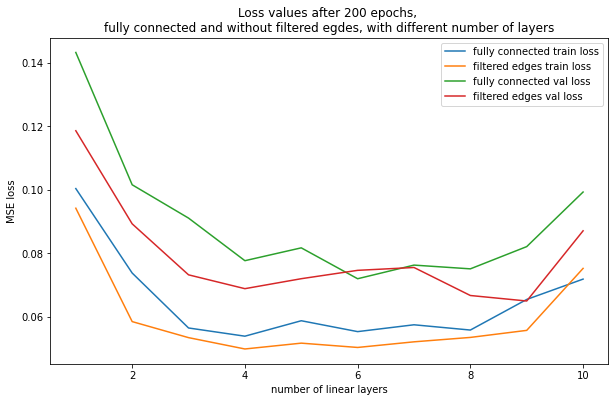

In [44]:
plt.figure(figsize=(10,6))
x = np.arange(1,11)
plt.plot(x,np.array(train_loss_list)[:, -1][::2], label="fully connected train loss")
plt.plot(x,np.array(train_loss_list)[:, -1][1::2], label="filtered edges train loss")
plt.plot(x,np.array(val_loss_list)[:, -1][::2], label="fully connected val loss")
plt.plot(x,np.array(val_loss_list)[:, -1][1::2], label="filtered edges val loss")
plt.legend()
plt.title("Loss values after 200 epochs, \nfully connected and without filtered egdes, with different number of layers")
plt.xlabel("number of linear layers")
plt.ylabel("MSE loss")
plt.show()

# Edge Prediction

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
model = Edgeweight_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                               conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader, val_loader,
                                                  criterion, epochs=500, device=device)


Epoch::   0%|                                          | 0/500 [00:22<?, ?it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Anaconda3\envs\torch_fish_env\lib\site-packages\IPython\core\interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-107888c5fd6e>", line 6, in <module>
    train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader, val_loader,
  File "C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\SwarmNet.py", line 77, in train_SwarmNet
    pred_lbl = model(data.pose, data.view, data.edge_index)
  File "D:\Anaconda3\envs\torch_fish_env\lib\site-packages\torch\nn\modules\module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\SwarmNet.py", line 164, in forward
    views = self.lrelu(self.encoder1(views))
  File "D:\Anaconda3\envs\torch_fish_env\lib\site-packages\torch\nn\modules\module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



  File "D:\Anaconda3\envs\torch_fish_env\lib\site-packages\torch\nn\modules\conv.py", line 297, in _conv_forward
    return F.conv1d(input, weight, bias, self.stride,
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda3\envs\torch_fish_env\lib\site-packages\IPython\core\interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda3\envs\torch_fish_env\lib\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "D:\Anaconda3\envs\torch_fish_env\lib\site-packages\IPython\core\interactiveshell.py", line 3434, in run_code
    self.showtraceback(running_compiled_code=True)
  File "D:\Anacond

In [8]:
PATH = "pascal_edge_prediction.pth"
save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)

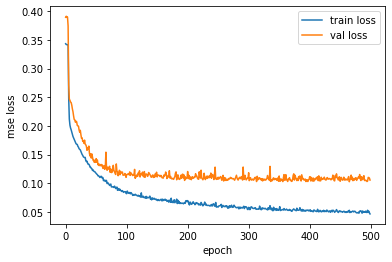

In [9]:
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("epoch")
plt.ylabel("mse loss")
plt.legend()
plt.show()

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PATH = "pascal_edge_prediction.pth"
model = Edgeweight_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                               conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)

In [8]:
prev_train_losses[200], prev_val_losses[200]

(0.06997927607686956, 0.12057771708350629)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PATH = f"variation_{0}_learned.pt"
model = Edgeweight_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                               conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)

In [ ]:
# plot edge weights vs relative orientation (substract absolute orientations)
# plot jointplot with colours based on zone of orientation, ...
# fully connected, filtered, learned weights compare with same n_layers, multiple runs with mean, std
# compare to non-graph model of similar complexity, maybe only remove all edges

In [ ]:
# - pi, %2pi, +pi

In [15]:
# dist1, dist2, dist3, dist4 = [], [], [], []
# radiants1, radiants2 = [], []
# for data in val_loader:
#     data = data.to(device)
#     edge_weights = model.get_edge_weights(data.pose, data.view, data.edge_index)
#     dist1.append(torch.cdist(data.pose[::2,None, :2], data.pose[1::2,None, :2], p=2.0).flatten().cpu().detach().numpy())
#     dist2.append((edge_weights[::2]).cpu().detach().numpy())
#     dist3.append(torch.cdist(data.pose[1::2,None, :2], data.pose[::2,None, :2], p=2.0).flatten().cpu().detach().numpy())
#     dist4.append((edge_weights[1::2]).cpu().detach().numpy())
#     radiants1.append(torch.cdist(data.pose[::2,None, 2:], data.pose[1::2,None, 2:], p=2.0).flatten().cpu().detach().numpy())
#     radiants2.append(torch.cdist(data.pose[1::2,None, 2:], data.pose[::2,None, 2:], p=2.0).flatten().cpu().detach().numpy())
# dist1, dist2 = np.concatenate(dist1), np.concatenate(dist2)
# dist3, dist4 = np.concatenate(dist3), np.concatenate(dist4)
# radiants1, radiants2 = np.concatenate(radiants1),   np.concatenate(radiants2)

In [7]:
def normalize_series(x):
    """Normalize series.

    Given a series of vectors, return a series of normalized vectors.
    Null vectors are mapped to `NaN` vectors.
    """
    return (x.T / np.linalg.norm(x, axis=-1)).T

In [8]:
def calculate_follow(a, b):
    """Calculate the follow metric.

    Given two series of poses - with X and Y coordinates of their
    positions as the first two elements
    return the follow metric from the first to the second series.
    """
    a_v = a[1:, :2] - a[:-1, :2]
    b_p = normalize_series(b[:-1, :2] - a[:-1, :2])
    return (a_v * b_p).sum(axis=-1)

In [9]:
import scipy

In [11]:
positions = {x:[] for x in range(2)}
edge_w = {x:{y:[] for y in range(2)} for x in range(2)}
turn_dict = {x:[] for x in range(2)}
for variation in range(1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    PATH = f"variation_{variation}_learned.pt"
    model = Edgeweight_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            edge_weights = model.get_edge_weights(data.pose, data.view, data.edge_index)
            turns = model(data.pose, data.view, data.edge_index).flatten().cpu().detach().numpy()
            for i in range(2):
                positions[i].append(data.pose[i::2].cpu().detach().numpy())
                turn_dict[i].append(turns[i::2])
                for j in range(2):
                    if i != j:
                        edge_w[i][j].append(edge_weights[(torch.remainder(data.edge_index[0], 2) == i) & (torch.remainder(data.edge_index[1], 2) == j)].cpu().detach().numpy())
                        
positions = np.stack(list((np.concatenate(positions[key]).reshape((100,199,3)) for key in positions)))
turns = np.stack(list((np.concatenate(turn_dict[key]).reshape((100,199)) for key in turn_dict)))
edge_w = np.stack(list((np.stack(list((np.concatenate(edge_w[0][key2]).reshape((100,199)) if 0 != key2 else np.zeros((100,199)) for key2 in edge_w[0]))) for key in edge_w))).squeeze()
euclidean_points = []
turn_points = []
edge_w_points = []
edge_w_points2 = []
radiants_points = []
follow_points = []
for i in range(2):
    for j in range(2):
        if i != j:
            for i_file in range(100):
                euclidean_points.append(np.diag(scipy.spatial.distance.cdist(positions[i, i_file, 1:, :2], positions[j, i_file, 1:, :2])))
                turn_points.append(turns[i, i_file, 1:])
                edge_w_points.append(edge_w[i, j, i_file, 1:])
                edge_w_points2.append(edge_w[j, i, i_file, 1:])
                radiants_points.append(np.diag(scipy.spatial.distance.cdist(positions[i, i_file, 1:, 2:], positions[j, i_file, 1:, 2:])))
                follow_points.append(calculate_follow(positions[i, i_file, :, :2], positions[j, i_file, :, :2]))
euclidean_points = np.concatenate(euclidean_points)
turn_points = np.concatenate(turn_points)
edge_w_points = np.concatenate(edge_w_points)
edge_w_points2 = np.concatenate(edge_w_points2)
radiants_points = np.concatenate(radiants_points)
radiants_points_pi = np.where(radiants_points > np.pi, -radiants_points, radiants_points) % np.pi
follow_points = np.concatenate(follow_points)

In [12]:
import pandas as pd

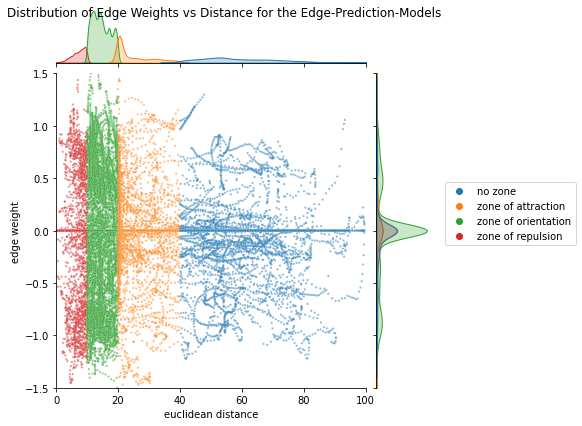

In [13]:
df = pd.DataFrame({
    'euclidean distance': euclidean_points,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
p = sns.jointplot(data=df, y="edge weight", x="euclidean distance", s=5, hue="zone", alpha=0.5)
p.fig.suptitle("Distribution of Edge Weights vs Distance for the Edge-Prediction-Models")
p.fig.get_axes()[0].legend().set_visible(False)
p.fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
p.ax_marg_y.set_ylim(-1.5,1.5)
p.ax_marg_x.set_xlim(0,100)
plt.show()

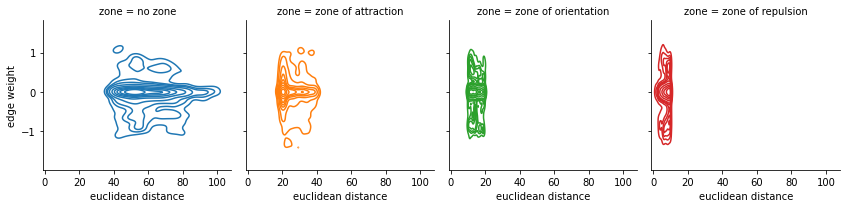

In [14]:
df = pd.DataFrame({
    'euclidean distance': euclidean_points,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
g = sns.FacetGrid(df, col="zone", hue="zone", margin_titles=True)
g.map_dataframe(sns.kdeplot, x="euclidean distance", y="edge weight")
p.fig.suptitle("Distribution of Edge Weights vs Distance for the Edge-Prediction-Models")
plt.show()

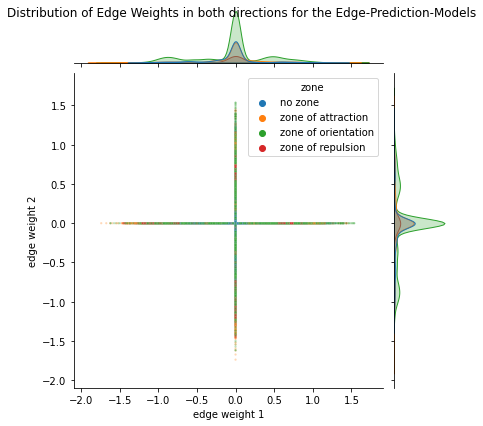

In [15]:
df = pd.DataFrame({
    'edge weight 1': edge_w_points,
    'edge weight 2': edge_w_points2,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
p = sns.jointplot(data=df, x="edge weight 1", y="edge weight 2", s=5, hue="zone", alpha=0.3)
p.fig.suptitle("Distribution of Edge Weights in both directions for the Edge-Prediction-Models")
# p.fig.get_axes()[0].legend().set_visible(False)
# p.fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# p.ax_marg_y.set_ylim(-1.5,1.5)
# p.ax_marg_x.set_xlim(-1.5,1.5)
plt.show()

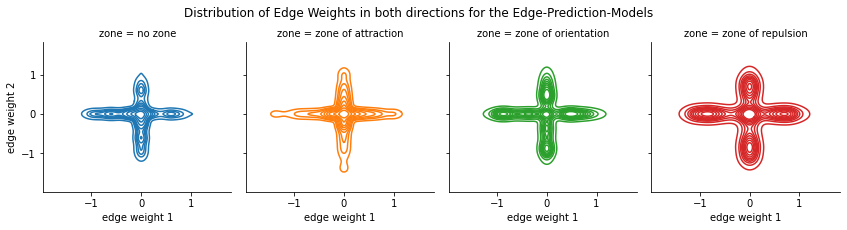

In [16]:
df = pd.DataFrame({
    'edge weight 1': edge_w_points,
    'edge weight 2': edge_w_points2,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
g = sns.FacetGrid(df, col="zone", hue="zone", margin_titles=True)
g.map_dataframe(sns.kdeplot, x="edge weight 1", y="edge weight 2")
#g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of Edge Weights in both directions for the Edge-Prediction-Models", y=1.05)
plt.show()
# g.set_axis_labels("Total bill ($)", "Tip ($)")
# g.set_titles(col_template="{col_name} patrons", row_template="{row_name}")
# g.set(xlim=(0, 60), ylim=(0, 12), xticks=[10, 30, 50], yticks=[2, 6, 10])

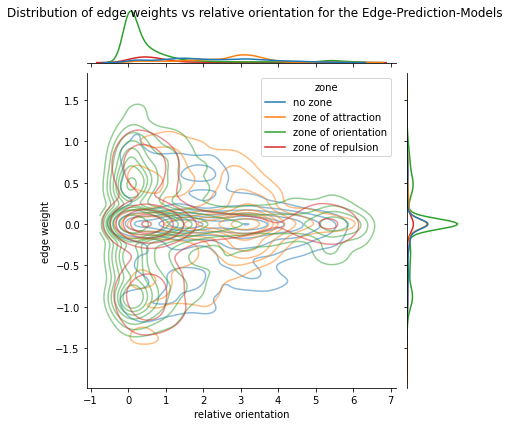

In [17]:
df = pd.DataFrame({
    'relative orientation': radiants_points,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
p = sns.jointplot(data=df, y="edge weight", x="relative orientation", kind='kde', hue="zone", alpha=0.5)
p.fig.suptitle("Distribution of edge weights vs relative orientation for the Edge-Prediction-Models")
# p.fig.get_axes()[0].legend().set_visible(False)
# p.fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# p.ax_marg_y.set_ylim(-1.5,1.5)
# p.ax_marg_x.set_xlim(-0.5,7)
plt.show()

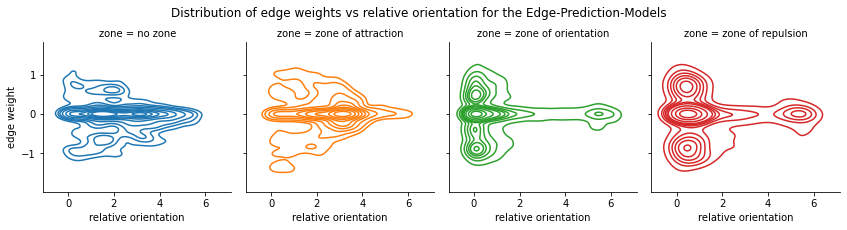

In [18]:
df = pd.DataFrame({
    'relative orientation': radiants_points,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})

g = sns.FacetGrid(df, col="zone", hue='zone', margin_titles=True)
g.map_dataframe(sns.kdeplot, x="relative orientation", y="edge weight")
# g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of edge weights vs relative orientation for the Edge-Prediction-Models", y=1.05)
plt.show()
# g.set_axis_labels("Total bill ($)", "Tip ($)")
# g.set_titles(col_template="{col_name} patrons", row_template="{row_name}")
# g.set(xlim=(0, 60), ylim=(0, 12), xticks=[10, 30, 50], yticks=[2, 6, 10])

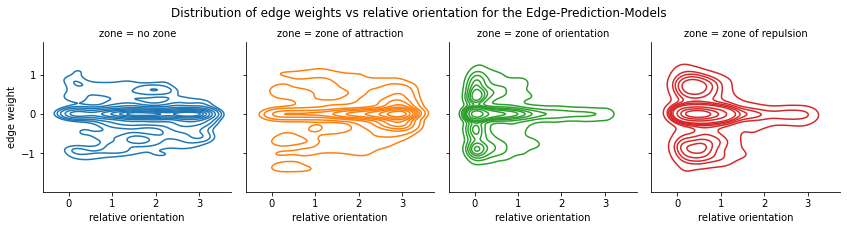

In [19]:
df = pd.DataFrame({
    'relative orientation': radiants_points_pi,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})

g = sns.FacetGrid(df, col="zone", hue='zone', margin_titles=True)
g.map_dataframe(sns.kdeplot, x="relative orientation", y="edge weight")
# g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of edge weights vs relative orientation for the Edge-Prediction-Models", y=1.05)
plt.show()
# g.set_axis_labels("Total bill ($)", "Tip ($)")
# g.set_titles(col_template="{col_name} patrons", row_template="{row_name}")
# g.set(xlim=(0, 60), ylim=(0, 12), xticks=[10, 30, 50], yticks=[2, 6, 10])

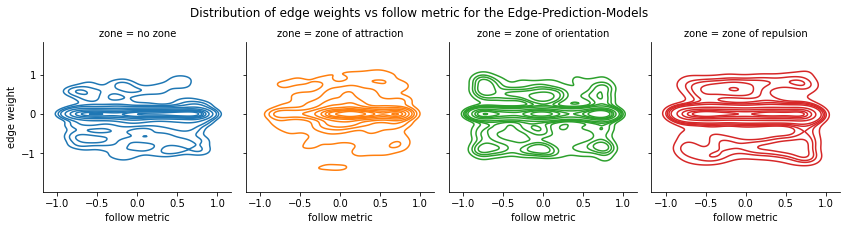

In [20]:
df = pd.DataFrame({
    'follow metric': follow_points,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})

g = sns.FacetGrid(df, col="zone", hue='zone', margin_titles=True)
g.map_dataframe(sns.kdeplot, x="follow metric", y="edge weight")
# g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of edge weights vs follow metric for the Edge-Prediction-Models", y=1.05)
plt.show()
# g.set_axis_labels("Total bill ($)", "Tip ($)")
# g.set_titles(col_template="{col_name} patrons", row_template="{row_name}")
# g.set(xlim=(0, 60), ylim=(0, 12), xticks=[10, 30, 50], yticks=[2, 6, 10])

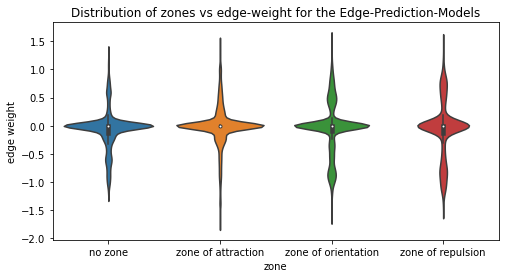

In [21]:
df = pd.DataFrame({
    'relative orientation': radiants_points,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
plt.figure(figsize=(8,4))
p = sns.violinplot(data=df, x='zone', y="edge weight")
plt.title("Distribution of zones vs edge-weight for the Edge-Prediction-Models")
# p.fig.get_axes()[0].legend().set_visible(False)
# p.fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# p.ax_marg_y.set_ylim(-0.5,7)
# p.ax_marg_x.set_xlim(-10,100)
plt.show()

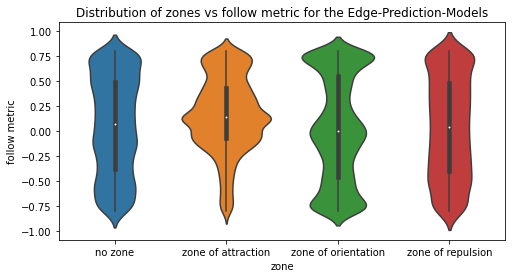

In [22]:
df = pd.DataFrame({
    'follow metric': follow_points,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
plt.figure(figsize=(8,4))
p = sns.violinplot(data=df, x='zone', y="follow metric")
plt.title("Distribution of zones vs follow metric for the Edge-Prediction-Models")
# p.fig.get_axes()[0].legend().set_visible(False)
# p.fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# p.ax_marg_y.set_ylim(-0.5,7)
# p.ax_marg_x.set_xlim(-10,100)
plt.show()

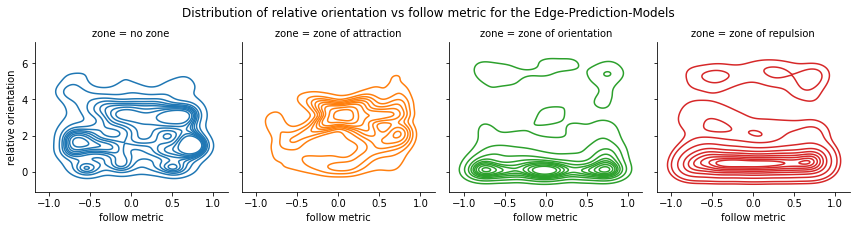

In [23]:
df = pd.DataFrame({
    'follow metric': follow_points,
    'relative orientation': radiants_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})

g = sns.FacetGrid(df, col="zone", hue='zone', margin_titles=True)
g.map_dataframe(sns.kdeplot, x="follow metric", y="relative orientation")
# g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of relative orientation vs follow metric for the Edge-Prediction-Models", y=1.05)
plt.show()
# g.set_axis_labels("Total bill ($)", "Tip ($)")
# g.set_titles(col_template="{col_name} patrons", row_template="{row_name}")
# g.set(xlim=(0, 60), ylim=(0, 12), xticks=[10, 30, 50], yticks=[2, 6, 10])

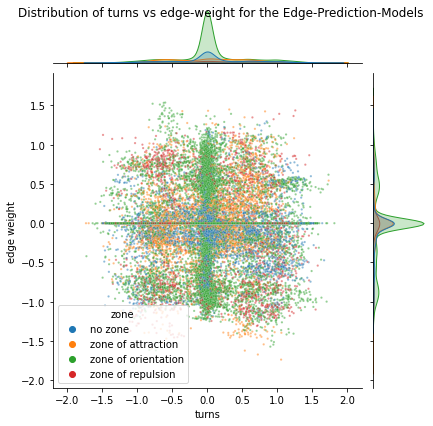

In [24]:
df = pd.DataFrame({
    'turns': turn_points,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
p = sns.jointplot(data=df, y="edge weight", x="turns", s=5, hue="zone", alpha=0.5)
p.fig.suptitle("Distribution of turns vs edge-weight for the Edge-Prediction-Models")
# p.fig.get_axes()[0].legend().set_visible(False)
# p.fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# p.ax_marg_y.set_ylim(-0.5,7)
# p.ax_marg_x.set_xlim(-10,100)
plt.show()

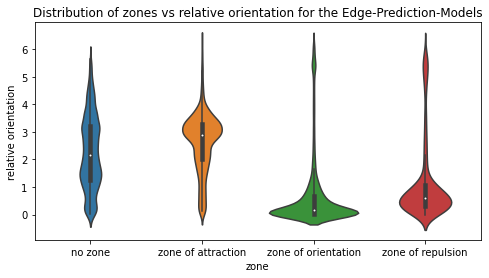

In [25]:
df = pd.DataFrame({
    'relative orientation': radiants_points,
    'euclidean distance': euclidean_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
plt.figure(figsize=(8,4))
p = sns.violinplot(data=df, x='zone', y="relative orientation")
plt.title("Distribution of zones vs relative orientation for the Edge-Prediction-Models")
# p.fig.get_axes()[0].legend().set_visible(False)
# p.fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# p.ax_marg_y.set_ylim(-0.5,7)
# p.ax_marg_x.set_xlim(-10,100)
plt.show()

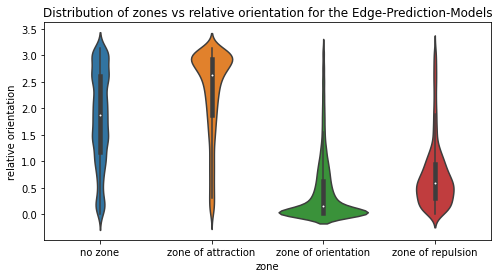

In [26]:
df = pd.DataFrame({
    'relative orientation': radiants_points_pi,
    'euclidean distance': euclidean_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
plt.figure(figsize=(8,4))
p = sns.violinplot(data=df, x='zone', y="relative orientation")
plt.title("Distribution of zones vs relative orientation for the Edge-Prediction-Models")
# p.fig.get_axes()[0].legend().set_visible(False)
# p.fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# p.ax_marg_y.set_ylim(-0.5,7)
# p.ax_marg_x.set_xlim(-10,100)
plt.show()

# Older Plots

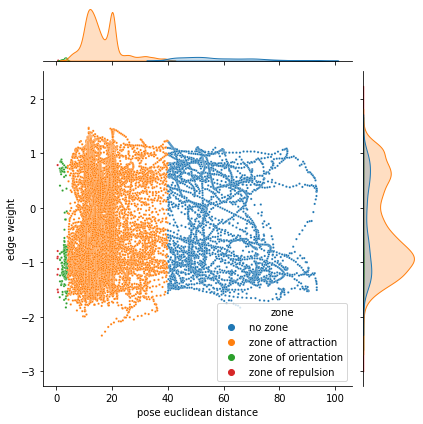

In [31]:
df = pd.DataFrame({
    'pose euclidean distance': np.concatenate((dist1, dist3)),
    'edge weight': np.concatenate((dist2, dist4)),
    'zone': ['zone of repulsion' if x < 1 else 'zone of orientation' if x < 4 else 'zone of attraction' if x < 40 else 'no zone' for x in np.concatenate((dist1, dist3))]})
ax = sns.jointplot(data=df, y="edge weight", x="pose euclidean distance", s=5, hue="zone")
plt.show()

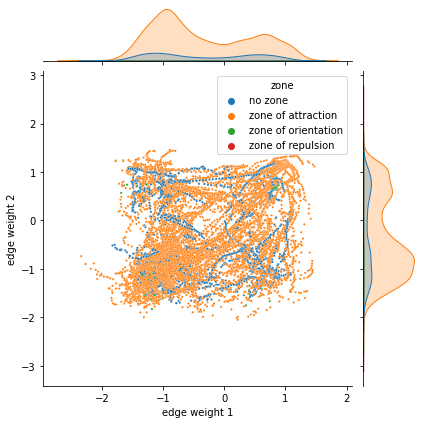

In [29]:
df = pd.DataFrame({
    'edge weight 1': dist2,
    'edge weight 2': dist4,
    'zone': ['zone of repulsion' if x < 1 else 'zone of orientation' if x < 4 else 'zone of attraction' if x < 40 else 'no zone' for x in dist1]})
ax = sns.jointplot(data=df, x="edge weight 1", y="edge weight 2", s=5, hue="zone")
plt.show()

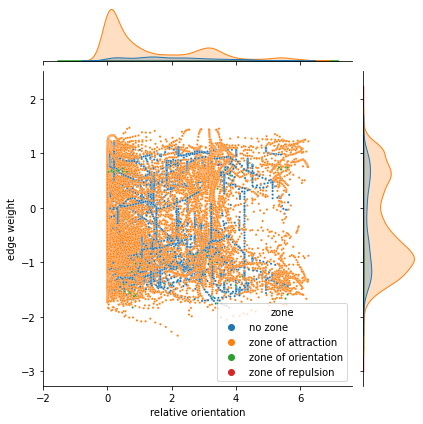

In [33]:
df = pd.DataFrame({
    'relative orientation': np.concatenate((radiants1, radiants2)),
    'edge weight': np.concatenate((dist2, dist4)),
    'zone': ['zone of repulsion' if x < 1 else 'zone of orientation' if x < 4 else 'zone of attraction' if x < 40 else 'no zone' for x in np.concatenate((dist1, dist3))]})
ax = sns.jointplot(data=df, y="edge weight", x="relative orientation", s=5, hue="zone")
plt.show()

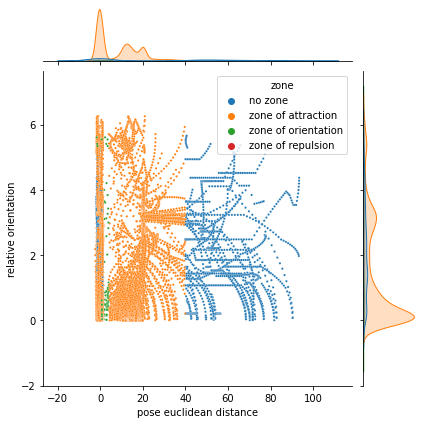

In [36]:
df = pd.DataFrame({
    'relative orientation': np.concatenate((radiants1, radiants2)),
    'pose euclidean distance': np.concatenate((dist1, dist2)),
    'zone': ['zone of repulsion' if x < 1 else 'zone of orientation' if x < 4 else 'zone of attraction' if x < 40 else 'no zone' for x in np.concatenate((dist1, dist3))]})
ax = sns.jointplot(data=df, x="pose euclidean distance", y="relative orientation", s=5, hue="zone")
plt.show()

# Train all variations of models 5 times
fully connected, filtered, learned weights, non-graph model <br>
compare with same n_layers, multiple runs with mean, std

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
train_loss_dict, val_loss_dict = {'fully':[[]]*5, 'filtered':[[]]*5, 'learned':[[]]*5, 'non-graph':[[]]*5}, {'fully':[[]]*5, 'filtered':[[]]*5, 'learned':[[]]*5, 'non-graph':[[]]*5}
for variation in range(0,5):
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader, val_loader,
                                                      criterion, epochs=800, device=device)
    train_loss_dict['fully'][variation].append(train_losses)
    val_loss_dict['fully'][variation].append(val_losses)
    PATH = f"variation_{variation}_fully.pt"
    save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)
    
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader_filter, val_loader_filter,
                                                      criterion, epochs=800, device=device)
    train_loss_dict['filtered'][variation].append(train_losses)
    val_loss_dict['filtered'][variation].append(val_losses)
    PATH = f"variation_{variation}_filtered.pt"
    save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)
    
    model = Edgeweight_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                               conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader, val_loader,
                                                  criterion, epochs=800, device=device)
    train_loss_dict['learned'][variation].append(train_losses)
    val_loss_dict['learned'][variation].append(val_losses)
    PATH = f"variation_{variation}_learned.pt"
    save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)
    
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader_nograph, val_loader_nograph,
                                                      criterion, epochs=800, device=device)
    train_loss_dict['non-graph'][variation].append(train_losses)
    val_loss_dict['non-graph'][variation].append(val_losses)
    PATH = f"variation_{variation}_nongraph.pt"
    save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)


[Train: 0.119][Val: 0.205]: 100%|██████████| 800/800 [1:00:12<00:00,  4.52s/it]


In [81]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loss_list, val_loss_list = [], []
for variation in range(0, 5):
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    PATH = f"variation_{variation}_fully.pt"
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    train_loss_list.append(prev_train_losses)
    val_loss_list.append(prev_val_losses)
    
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    PATH = f"variation_{variation}_filtered.pt"
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    train_loss_list.append(prev_train_losses)
    val_loss_list.append(prev_val_losses)
    
    model = Edgeweight_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                               conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    PATH = f"variation_{variation}_learned.pt"
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    train_loss_list.append(prev_train_losses)
    val_loss_list.append(prev_val_losses)
    
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    PATH = f"variation_{variation}_nongraph.pt"
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    train_loss_list.append(prev_train_losses)
    val_loss_list.append(prev_val_losses)
train_loss_list = np.array(train_loss_list)
val_loss_list = np.array(val_loss_list)

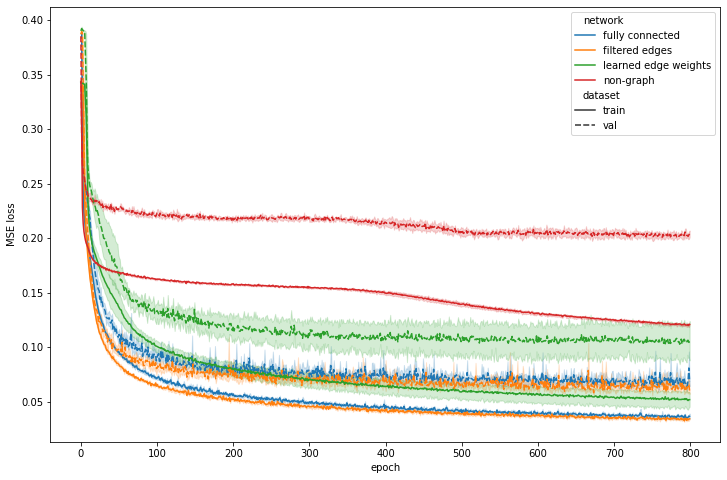

In [91]:
df = pd.DataFrame({
    'epoch': np.tile(np.arange(800),40),
    'MSE loss': np.concatenate((train_loss_list.flatten(), val_loss_list.flatten())),
    'network': np.array((["fully connected"]*(800) + ["filtered edges"]*(800) + ["learned edge weights"]*(800) + ["non-graph"]*(800))*10),
    'dataset': np.array(["train"]*(800*20) + ["val"]*(800*20))})
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.lineplot(ax=ax, data=df, x="epoch", y="MSE loss", hue="network", style="dataset")
plt.show()

# Couzin Dataset

In [3]:
raycast = fish_models.Raycast(
            n_fish_bins=150,
            n_wall_raycasts=150,
            fov_angle_fish_bins=2*np.pi,
            fov_angle_wall_raycasts=2*np.pi,
            world_bounds=([-50, -50], [50, 50]),
            view_of = ["fish", "fish_oris", "walls"]
        )

In [4]:
BATCH_SIZE = 320
data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\couzin_torus\couzin_torus\train"
dset = fish_models.IoDataset(data_folder, raycast, output_strings=["poses", "actions", "views"], max_files=500)
train_loader = create_swarm_dataset(dset["poses"], dset["actions"], dset["views"], batchsize=BATCH_SIZE, filter_distance=None)
train_loader_filter = create_swarm_dataset(dset["poses"], dset["actions"], dset["views"], batchsize=BATCH_SIZE, filter_distance=40)
train_loader_nograph = create_swarm_dataset(dset["poses"], dset["actions"], dset["views"], batchsize=BATCH_SIZE, filter_distance=0)
del dset
data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\couzin_torus\couzin_torus\test"
dset_test = fish_models.IoDataset(data_folder,raycast,output_strings=["poses", "actions", "views"],max_files=50)
test_loader = create_swarm_dataset(dset_test["poses"], dset_test["actions"], dset_test["views"], batchsize=BATCH_SIZE, filter_distance=None)
test_loader_filter = create_swarm_dataset(dset_test["poses"], dset_test["actions"], dset_test["views"], batchsize=BATCH_SIZE, filter_distance=40)
test_loader_nograph = create_swarm_dataset(dset_test["poses"], dset_test["actions"], dset_test["views"], batchsize=BATCH_SIZE, filter_distance=0)
del dset_test
data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\couzin_torus\couzin_torus\validation"
dset_val = fish_models.IoDataset(data_folder,raycast,output_strings=["poses", "actions", "views"],max_files=50)
val_loader = create_swarm_dataset(dset_val["poses"], dset_val["actions"], dset_val["views"], batchsize=BATCH_SIZE, filter_distance=None)
val_loader_filter = create_swarm_dataset(dset_val["poses"], dset_val["actions"], dset_val["views"], batchsize=BATCH_SIZE, filter_distance=40)
val_loader_nograph = create_swarm_dataset(dset_val["poses"], dset_val["actions"], dset_val["views"], batchsize=BATCH_SIZE, filter_distance=0)
del dset_val

Loading data from 197 files.


100%|████████████████████████████████████████| 197/197 [00:06<00:00, 28.57it/s]


None
Calculating views from 197 files.


100%|████████████████████████████████████████| 197/197 [02:13<00:00,  1.47it/s]


Reducing shape of poses.


100%|█████████████████████████████████████| 197/197 [00:00<00:00, 24485.94it/s]


Reducing shape of actions.


100%|█████████████████████████████████████| 197/197 [00:00<00:00, 12657.06it/s]


Reducing shape of views.


100%|███████████████████████████████████████| 197/197 [00:00<00:00, 272.08it/s]


Status of IoDataset:
poses	(197, 8, 749, 3):	consisting of x, y, orientation.
actions	(197, 8, 749, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(197, 8, 749, 450):	consisting of 150 fish bins, 150 fish oris and 150 wall raycasts.

Note: There will exist NaNs in the output of this dataset. You might want to use the reduce_dim parameter to get rid of them


c:\users\olaf\onedrive\öffentlich\master\researchinternship\fish_models\src\fish_models\datasets\io_dataset.py:523: UserWarning: There will exist NaNs in the output of this dataset. You might want to use the reduce_dim parameter to get rid of them
  warn(


Loading data from 24 files.


100%|██████████████████████████████████████████| 24/24 [00:03<00:00,  7.62it/s]


None
Calculating views from 24 files.


100%|██████████████████████████████████████████| 24/24 [00:20<00:00,  1.19it/s]


Reducing shape of poses.


100%|██████████████████████████████████████████████████| 24/24 [00:00<?, ?it/s]


Reducing shape of actions.


100%|██████████████████████████████████████████████████| 24/24 [00:00<?, ?it/s]


Reducing shape of views.


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 347.65it/s]


Status of IoDataset:
poses	(24, 8, 749, 3):	consisting of x, y, orientation.
actions	(24, 8, 749, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(24, 8, 749, 450):	consisting of 150 fish bins, 150 fish oris and 150 wall raycasts.

Note: There will exist NaNs in the output of this dataset. You might want to use the reduce_dim parameter to get rid of them
Loading data from 24 files.


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 26.05it/s]


None
Calculating views from 24 files.


100%|██████████████████████████████████████████| 24/24 [00:18<00:00,  1.28it/s]


Reducing shape of poses.


100%|███████████████████████████████████████| 24/24 [00:00<00:00, 12002.30it/s]


Reducing shape of actions.


100%|███████████████████████████████████████| 24/24 [00:00<00:00, 12123.73it/s]


Reducing shape of views.


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 342.98it/s]


Status of IoDataset:
poses	(24, 8, 749, 3):	consisting of x, y, orientation.
actions	(24, 8, 749, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(24, 8, 749, 450):	consisting of 150 fish bins, 150 fish oris and 150 wall raycasts.

Note: There will exist NaNs in the output of this dataset. You might want to use the reduce_dim parameter to get rid of them


## Training with different number of layers

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
train_loss_list, val_loss_list = [], []
for n_linears in range(1, 11):
    PATH = f"couzin_model_{n_linears}_layer.pt"
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader, val_loader,
                                                      criterion, epochs=200, device=device)
    save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)
    print(f"fully: {n_linears} linear layer: train loss: {train_losses[-1]:.3f}, val loss: {val_losses[-1]:.3f}")
    train_loss_list.append(train_losses)
    val_loss_list.append(val_losses)
    
    PATH = f"couzin_model_{n_linears}_layer_filtered.pt"
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader_filter, val_loader_filter,
                                                      criterion, epochs=200, device=device)
    save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)
    print(f"filter: {n_linears} linear layer: train loss: {train_losses[-1]:.3f}, val loss: {val_losses[-1]:.3f}")
    train_loss_list.append(train_losses)
    val_loss_list.append(val_losses)

[Train: 0.104][Val: 0.181]: 100%|████████████| 200/200 [22:39<00:00,  6.80s/it]


fully: 1 linear layer: train loss: 0.104, val loss: 0.181


[Train: 0.103][Val: 0.200]: 100%|████████████| 200/200 [22:55<00:00,  6.88s/it]


filter: 1 linear layer: train loss: 0.103, val loss: 0.200


[Train: 0.080][Val: 0.184]: 100%|████████████| 200/200 [22:32<00:00,  6.76s/it]


fully: 2 linear layer: train loss: 0.080, val loss: 0.184


[Train: 0.083][Val: 0.179]: 100%|████████████| 200/200 [20:06<00:00,  6.03s/it]


filter: 2 linear layer: train loss: 0.083, val loss: 0.179


[Train: 0.068][Val: 0.164]: 100%|████████████| 200/200 [21:24<00:00,  6.42s/it]


fully: 3 linear layer: train loss: 0.068, val loss: 0.164


[Train: 0.070][Val: 0.163]: 100%|████████████| 200/200 [18:07<00:00,  5.44s/it]


filter: 3 linear layer: train loss: 0.070, val loss: 0.163


[Train: 0.069][Val: 0.159]: 100%|████████████| 200/200 [18:23<00:00,  5.52s/it]


fully: 4 linear layer: train loss: 0.069, val loss: 0.159


[Train: 0.065][Val: 0.172]: 100%|████████████| 200/200 [18:13<00:00,  5.47s/it]


filter: 4 linear layer: train loss: 0.065, val loss: 0.172


[Train: 0.066][Val: 0.157]: 100%|████████████| 200/200 [18:55<00:00,  5.68s/it]


fully: 5 linear layer: train loss: 0.066, val loss: 0.157


[Train: 0.071][Val: 0.170]: 100%|████████████| 200/200 [18:57<00:00,  5.69s/it]


filter: 5 linear layer: train loss: 0.071, val loss: 0.170


[Train: 0.065][Val: 0.162]: 100%|████████████| 200/200 [19:42<00:00,  5.91s/it]


fully: 6 linear layer: train loss: 0.065, val loss: 0.162


[Train: 0.064][Val: 0.149]: 100%|████████████| 200/200 [19:54<00:00,  5.97s/it]


filter: 6 linear layer: train loss: 0.064, val loss: 0.149


[Train: 0.094][Val: 0.132]: 100%|████████████| 200/200 [20:26<00:00,  6.13s/it]


fully: 7 linear layer: train loss: 0.094, val loss: 0.132


[Train: 0.086][Val: 0.147]: 100%|████████████| 200/200 [20:31<00:00,  6.16s/it]


filter: 7 linear layer: train loss: 0.086, val loss: 0.147


[Train: 0.068][Val: 0.155]: 100%|████████████| 200/200 [21:15<00:00,  6.38s/it]


fully: 8 linear layer: train loss: 0.068, val loss: 0.155


[Train: 0.080][Val: 0.136]: 100%|████████████| 200/200 [21:15<00:00,  6.38s/it]


filter: 8 linear layer: train loss: 0.080, val loss: 0.136


[Train: 0.091][Val: 0.152]: 100%|████████████| 200/200 [22:03<00:00,  6.62s/it]


fully: 9 linear layer: train loss: 0.091, val loss: 0.152


[Train: 0.130][Val: 0.158]: 100%|████████████| 200/200 [21:56<00:00,  6.58s/it]


filter: 9 linear layer: train loss: 0.130, val loss: 0.158


[Train: 0.349][Val: 0.334]: 100%|████████████| 200/200 [22:48<00:00,  6.84s/it]


fully: 10 linear layer: train loss: 0.349, val loss: 0.334


[Train: 0.079][Val: 0.148]: 100%|████████████| 200/200 [22:37<00:00,  6.79s/it]

filter: 10 linear layer: train loss: 0.079, val loss: 0.148


### Load Models again

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loss_list, val_loss_list = [], []
for n_linears in range(1, 11):
    PATH = f"couzin_model_{n_linears}_layer.pt"
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    train_loss_list.append(prev_train_losses)
    val_loss_list.append(prev_val_losses)
    
    PATH = f"couzin_model_{n_linears}_layer_filtered.pt"
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    train_loss_list.append(prev_train_losses)
    val_loss_list.append(prev_val_losses)

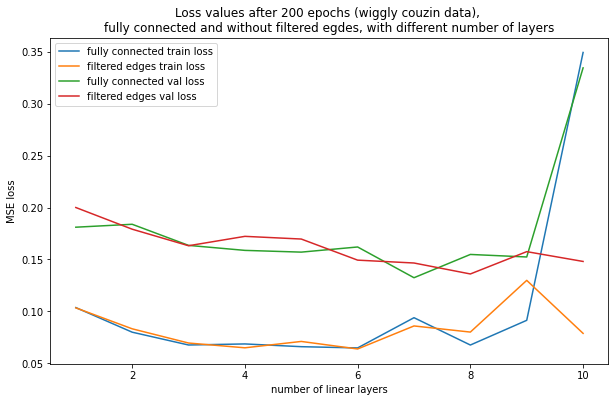

In [9]:
plt.figure(figsize=(10,6))
x = np.arange(1,11)
plt.plot(x,np.array(train_loss_list)[:, -1][::2], label="fully connected train loss")
plt.plot(x,np.array(train_loss_list)[:, -1][1::2], label="filtered edges train loss")
plt.plot(x,np.array(val_loss_list)[:, -1][::2], label="fully connected val loss")
plt.plot(x,np.array(val_loss_list)[:, -1][1::2], label="filtered edges val loss")
plt.legend()
plt.title("Loss values after 200 epochs (wiggly couzin data), \nfully connected and without filtered egdes, with different number of layers")
plt.xlabel("number of linear layers")
plt.ylabel("MSE loss")
plt.show()

## Train all variations of models 3 times
fully connected, filtered, learned weights, non-graph model <br>
compare with same n_layers, multiple runs with mean, std

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
train_loss_list, val_loss_list = [], []
for variation in range(1,3):
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader, val_loader,
                                                      criterion, epochs=800, device=device)
    train_loss_list.append(train_losses)
    val_loss_list.append(val_losses)
    PATH = f"moritz_variation_{variation}_fully.pt"
    save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)
    
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader_filter, val_loader_filter,
                                                      criterion, epochs=800, device=device)
    train_loss_list.append(train_losses)
    val_loss_list.append(val_losses)
    PATH = f"moritz_variation_{variation}_filtered.pt"
    save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)
    
#     model = Edgeweight_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
#                                conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#     train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader, val_loader,
#                                                   criterion, epochs=800, device=device)
#     train_loss_list.append(train_losses)
#     val_loss_list.append(val_losses)
#     PATH = f"moritz_variation_{variation}_learned.pt"
#     save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)
    
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader_nograph, val_loader_nograph,
                                                      criterion, epochs=800, device=device)
    train_loss_list.append(train_losses)
    val_loss_list.append(val_losses)
    PATH = f"moritz_variation_{variation}_nongraph.pt"
    save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)
train_loss_list = np.array(train_loss_list)
val_loss_list = np.array(val_loss_list)

[Train: 0.068][Val: 0.150]: 100%|██████████| 800/800 [1:20:33<00:00,  6.04s/it]


In [46]:
import sys, importlib
importlib.reload(sys.modules['SwarmNet'])
from SwarmNet import Edgeweight_SwarmNet

In [47]:
for variation in range(0,3):
    model = Edgeweight_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                               conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader, val_loader,
                                                  criterion, epochs=800, device=device)
    train_loss_list.append(train_losses)
    val_loss_list.append(val_losses)
    PATH = f"moritz_variation_{variation}_learned.pt"
    save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)

[Train: 0.047][Val: 0.145]:  53%|██████▎     | 421/800 [53:18<47:59,  7.60s/it]


KeyboardInterrupt: 

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loss_list, val_loss_list = [], []
for variation in range(0, 3):
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    PATH = f"moritz_variation_{variation}_fully.pt"
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    train_loss_list.append(prev_train_losses)
    val_loss_list.append(prev_val_losses)
    
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    PATH = f"moritz_variation_{variation}_filtered.pt"
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    train_loss_list.append(prev_train_losses)
    val_loss_list.append(prev_val_losses)
    
#     model = Edgeweight_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
#                                conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#     PATH = f"moritz_variation_{variation}_learned.pt"
#     epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
#     train_loss_list.append(prev_train_losses)
#     val_loss_list.append(prev_val_losses)
    
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    PATH = f"moritz_variation_{variation}_nongraph.pt"
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    train_loss_list.append(prev_train_losses)
    val_loss_list.append(prev_val_losses)
train_loss_list = np.array(train_loss_list)
val_loss_list = np.array(val_loss_list)

In [44]:
with torch.no_grad():
    shapes, shapes2, shapes3 = [], [], []
    for i in train_loader:
        shapes.append(i.edge_index.shape[1])
        shapes2.append(i.pose.shape[0])
        shapes3.append((i.pose[i.edge_index]).shape[1])
np.unique(shapes), np.unique(shapes2),np.unique(shapes3)

(array([    0,   614,   640,  1500,  1848,  3840,  4254,  9600, 12122,
        17920]),
 array([ 264,  320,  627,  640,  812, 1280, 1326, 1920, 2114, 2560]),
 array([    0,   614,   640,  1500,  1848,  3840,  4254,  9600, 12122,
        17920]))

In [45]:
for i in range(1000):
    print(shapes[i], shapes2[i],shapes3[i])

0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0
0 320 0


IndexError: list index out of range

In [35]:
i.pose[i.edge_index].shape

torch.Size([2, 1848, 3])

In [37]:
i.edge_index.shape

torch.Size([2, 1848])

In [31]:
torch.unique(i.edge_index).view((-1, 1))

tensor([], size=(0, 1), dtype=torch.int64)

In [26]:
next(iter(train_loader))

DataBatch(edge_index=[2, 0], y=[320], pose=[320, 3], view=[320, 3, 150], num_nodes=320, batch=[320], ptr=[321])

In [21]:
1280 /4

320.0

In [24]:
320 *4*3

3840

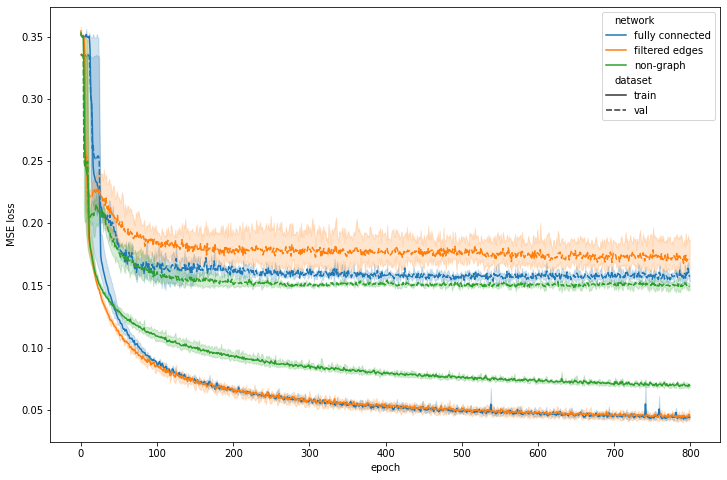

In [14]:
df = pd.DataFrame({
    'epoch': np.tile(np.arange(800),18),
    'MSE loss': np.concatenate((train_loss_list.flatten(), val_loss_list.flatten())),
    'network': np.array((["fully connected"]*(800) + ["filtered edges"]*(800) + ["non-graph"]*(800))*6),
    'dataset': np.array(["train"]*(800*9) + ["val"]*(800*9))})
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.lineplot(ax=ax, data=df, x="epoch", y="MSE loss", hue="network", style="dataset")
plt.show()

In [ ]:
df = pd.DataFrame({
    'epoch': np.tile(np.arange(800),24),
    'MSE loss': np.concatenate((train_loss_list.flatten(), val_loss_list.flatten())),
    'network': np.array((["fully connected"]*(800) + ["filtered edges"]*(800) + ["learned edge weights"]*(800) + ["non-graph"]*(800))*6),
    'dataset': np.array(["train"]*(800*12) + ["val"]*(800*12))})
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.lineplot(ax=ax, data=df, x="epoch", y="MSE loss", hue="network", style="dataset")
plt.show()

## Load Checkpoint

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Pose_plus_Ray_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                               conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

PATH = ""
epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, path=PATH)

model.eval()

# Build Fish Model from Torch Model

In [9]:
model.eval()
model.to("cpu")
raymodel = CouzinModel(model=model, raycast=raycast, view_width=150)
generator = fish_models.TrackGenerator([raymodel], world_size=[100,100], frequency=10)

100%|███████████████████████████████████████| 199/199 [00:01<00:00, 147.16it/s]


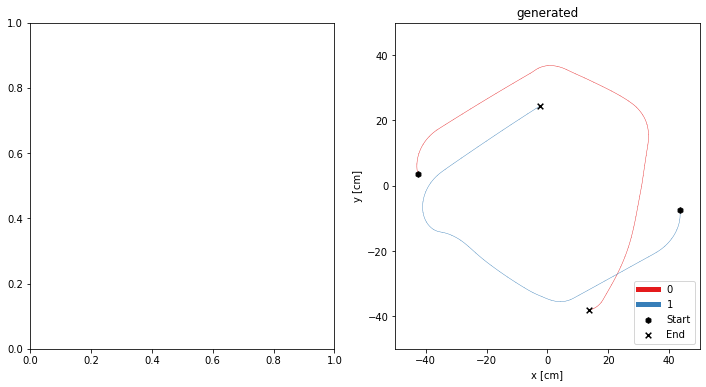

In [13]:
n=2
fig, axs = plt.subplots(1,2, figsize=(12,6))
# f = generator.as_io_file(swarm_poses[0,:n,:,:])
# f.plot(lw_distances=True, ax=axs[0])
# axs[0].set_title("true")
track = generator.create_track(n_guppies=2, trackset_len=199)#, initial_poses=swarm_poses[0,:n,0,:])
f = generator.as_io_file(track)
f.plot(lw_distances=True, ax=axs[1])
axs[1].set_title("generated")
plt.show()

In [14]:
track.shape

(2, 199, 3)

In [ ]:
# gucken nach einzelnen loss ausreißern
# plot/animation von track mit edge weight für 6 und 2 fische

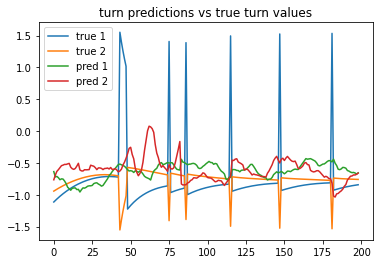

In [26]:
# 1 layer
plt.plot(swarm_actions[0,0,:,1], label="true 1")
plt.plot(swarm_actions[0,1,:,1], label="true 2")
plt.title("turn true turn values")
plt.legend()
plt.show()
plt.plot(np.array(raymodel.chosen_actions)[0], label="pred 1")
plt.plot(np.array(raymodel.chosen_actions)[1], label="pred 2")
plt.title("turn predicted turn values")
plt.legend()
plt.show()

100%|███████████████████████████████████████| 199/199 [00:00<00:00, 213.29it/s]


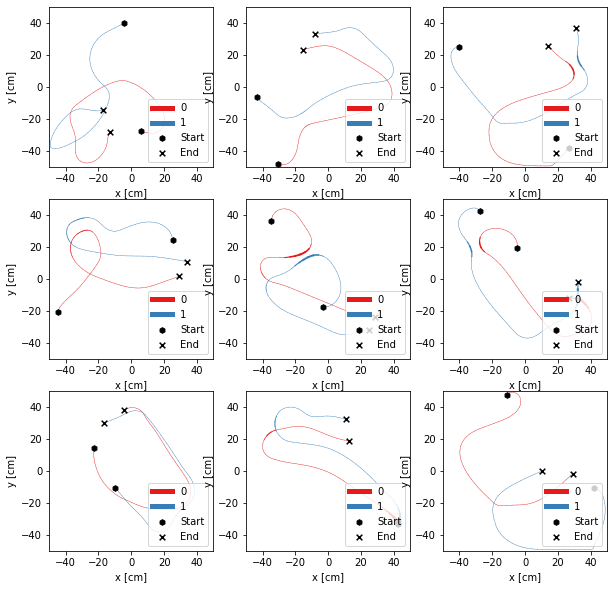

In [27]:
# 1 layer
fig, axs = plt.subplots(3,3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        track = generator.create_track(n_guppies=2, trackset_len=swarm_poses.shape[2])
        f = generator.as_io_file(track)
        f.plot(lw_distances=True, ax=axs[i,j])
plt.show()

# Overarching Evaluation

In [28]:
paths = []
labels = []
model_path = r"D:\ResearchInternshipData\pascal_data_edge_filter1"
model_label = "1 layer Model Data"
for i in range(200):
    track = generator.create_track(n_guppies=n, trackset_len=swarm_poses.shape[2])
    filename = r"D:\ResearchInternshipData\pascal_data_edge_filter1\track_" + str(i+1) + ".hdf5"
    f = generator.as_io_file(track, filename)
    paths.append(filename)
    labels.append("track_" + str(i+1))
f.close() 

100%|███████████████████████████████████████| 199/199 [00:00<00:00, 209.85it/s]


In [46]:
paths = []
labels = []
model_path2 = r"D:\ResearchInternshipData\pascal_data_edge_filter3"
model_label2 = "3 layer Model Data"
for i in range(200):
    track = generator.create_track(n_guppies=n, trackset_len=swarm_poses.shape[2])
    filename = r"D:\ResearchInternshipData\pascal_data_edge_filter3\track_" + str(i+1) + ".hdf5"
    f = generator.as_io_file(track, filename)
    paths.append(filename)
    labels.append("track_" + str(i+1))
f.close() 

100%|███████████████████████████████████████| 199/199 [00:01<00:00, 157.79it/s]


In [67]:
# for i, pose in enumerate(swarm_poses[:,:,:,:]):
#     f = generator.as_io_file(pose, r"D:\ResearchInternshipData\pascal_train\file_" + str(i) + ".hdf5")
#     f.close()

In [29]:
import robofish.evaluate.evaluate as robo_eval

In [31]:
# f1 = r"D:\ResearchInternshipData\pascal_train"
f1 = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\fish_models\storage\raw_data\pascal_vanilla_couzin\2fish_200t_10hz_vanilla\train"

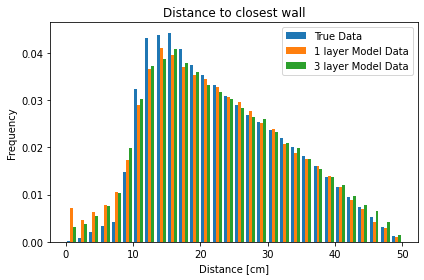

In [47]:
robo_eval.evaluate_distance_to_wall([f1, model_path, model_path2], ["True Data", model_label, model_label2])
plt.show()

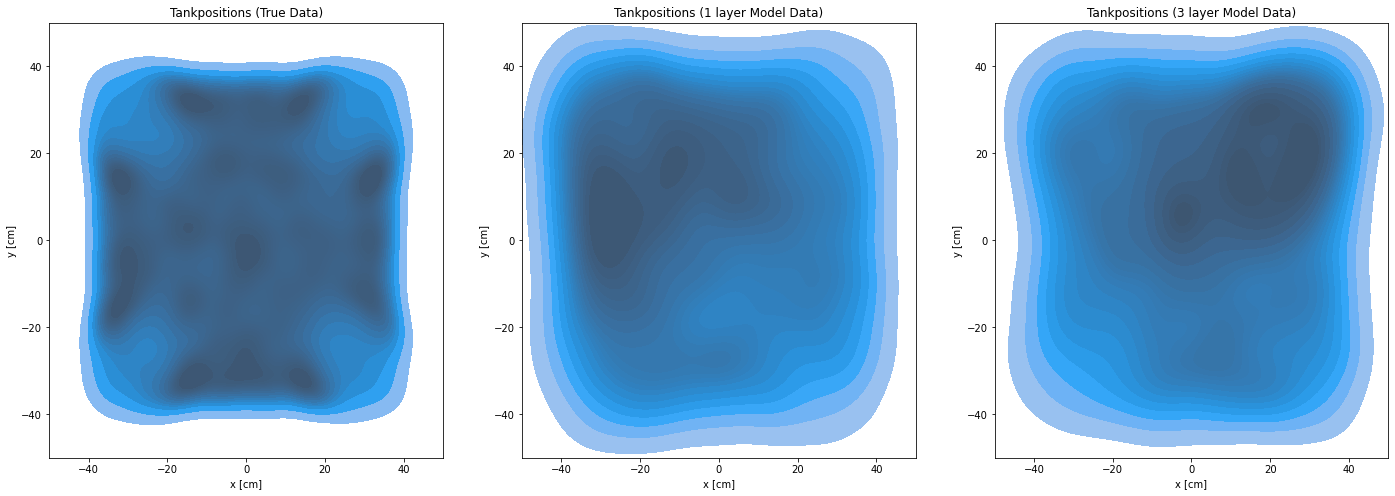

In [48]:
robo_eval.evaluate_tank_position([f1, model_path, model_path2], ["True Data", model_label, model_label2])
plt.show()

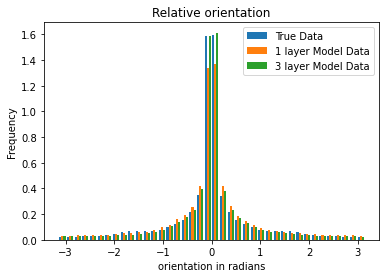

In [49]:
robo_eval.evaluate_relative_orientation([f1, model_path, model_path2], ["True Data", model_label, model_label2])
plt.show()

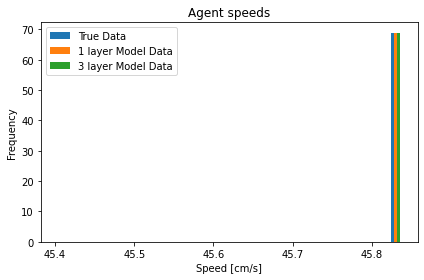

In [50]:
robo_eval.evaluate_speed([f1, model_path, model_path2], ["True Data", model_label, model_label2])
plt.show()

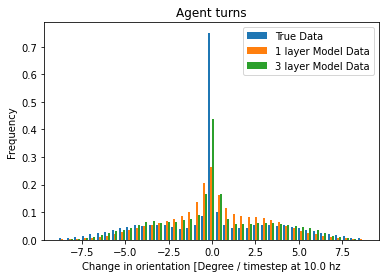

In [51]:
robo_eval.evaluate_turn([f1, model_path, model_path2], ["True Data", model_label, model_label2])
plt.show()

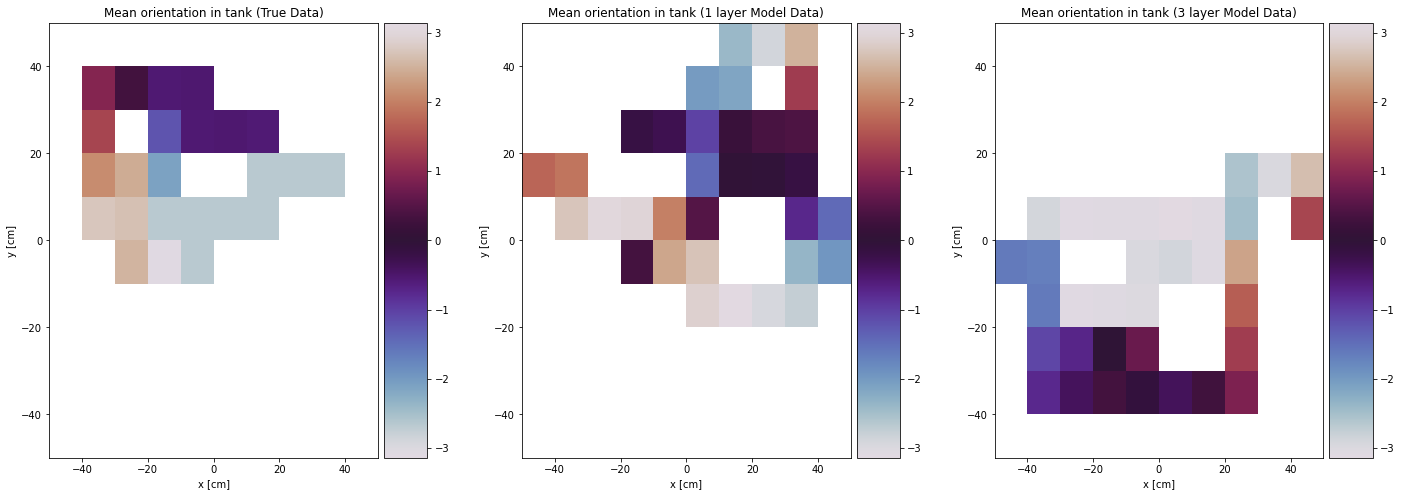

In [52]:
robo_eval.evaluate_orientation([f1, model_path, model_path2], ["True Data", model_label, model_label2])
plt.show()

<Figure size 576x576 with 0 Axes>

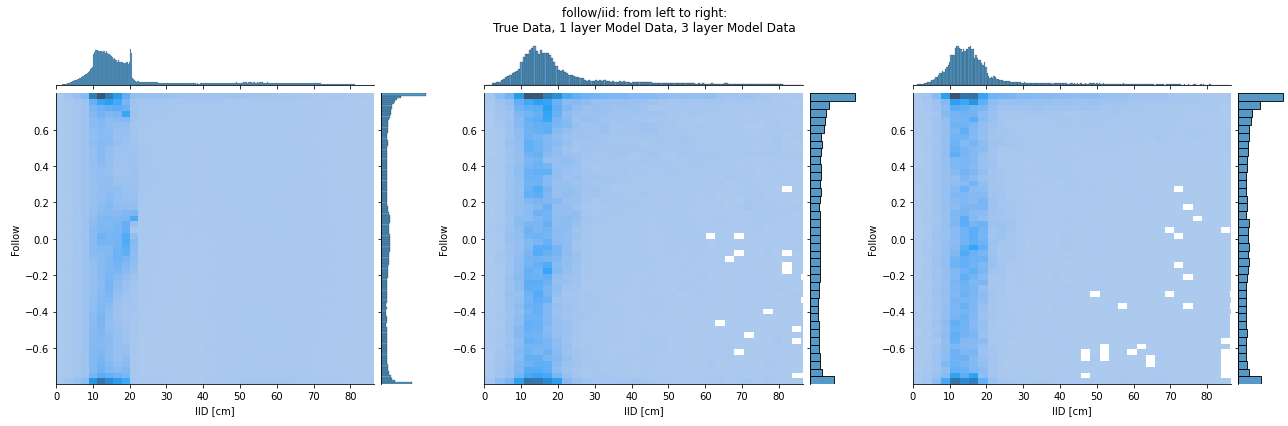

In [53]:
plt.figure(figsize=(8,8))
robo_eval.evaluate_follow_iid([f1, model_path, model_path2], ["True Data", model_label, model_label2])
plt.tight_layout()
plt.show()